# **Classification Model for categorizing weight**

## **1. Importing Libraries**

In [28]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

## **2. Loading and Cleaning the Dataset**

In [29]:
data_path = 'bodyPerformance.csv'
data = pd.read_csv(data_path)

data = data[['age', 'gender', 'height_cm', 'weight_kg']]

data.dropna(inplace=True)

data['gender'] = data['gender'].map({'Male': 1, 'Female': 0})


## **3. Handling Outliers**

In [30]:
for col in ['height_cm', 'weight_kg']:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]


## **4. Feature Engineering**

In [31]:
data['BMI'] = data.apply(lambda row: row['weight_kg'] / ((row['height_cm'] / 100) ** 2), axis=1)

def categorize_bmi(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi < 24.9:
        return "Ideal"
    elif 25 <= bmi < 29.9:
        return "Overweight"
    else:
        return "Obese"

data['BMI_Category'] = data['BMI'].apply(categorize_bmi)

label_encoder = LabelEncoder()
data['BMI_Category_Encoded'] = label_encoder.fit_transform(data['BMI_Category'])


## **5. Preparing the Dataset**

In [32]:
X = data[['age', 'gender', 'height_cm', 'weight_kg']]
y = data['BMI_Category_Encoded']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X = np.nan_to_num(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


## **6. Creating the Neural Network**

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],),
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## **7. Training the Model**

In [25]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32)


Epoch 1/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7343 - loss: 0.8833 - val_accuracy: 0.9280 - val_loss: 0.2941
Epoch 2/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9357 - loss: 0.2549 - val_accuracy: 0.9518 - val_loss: 0.1735
Epoch 3/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9562 - loss: 0.1530 - val_accuracy: 0.9675 - val_loss: 0.1235
Epoch 4/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9677 - loss: 0.1120 - val_accuracy: 0.9645 - val_loss: 0.1083
Epoch 5/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9725 - loss: 0.0975 - val_accuracy: 0.9754 - val_loss: 0.0895
Epoch 6/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9748 - loss: 0.0842 - val_accuracy: 0.9754 - val_loss: 0.0820
Epoch 7/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9755 - loss: 0.0761 - val_accuracy: 0.9701 - val_loss: 0.0808
Epoch 8/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9742 - loss: 0.0731 - val_accu

## **8. Evaluating the Model**

In [26]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9947 - loss: 0.0247
Test Accuracy: 99.33%


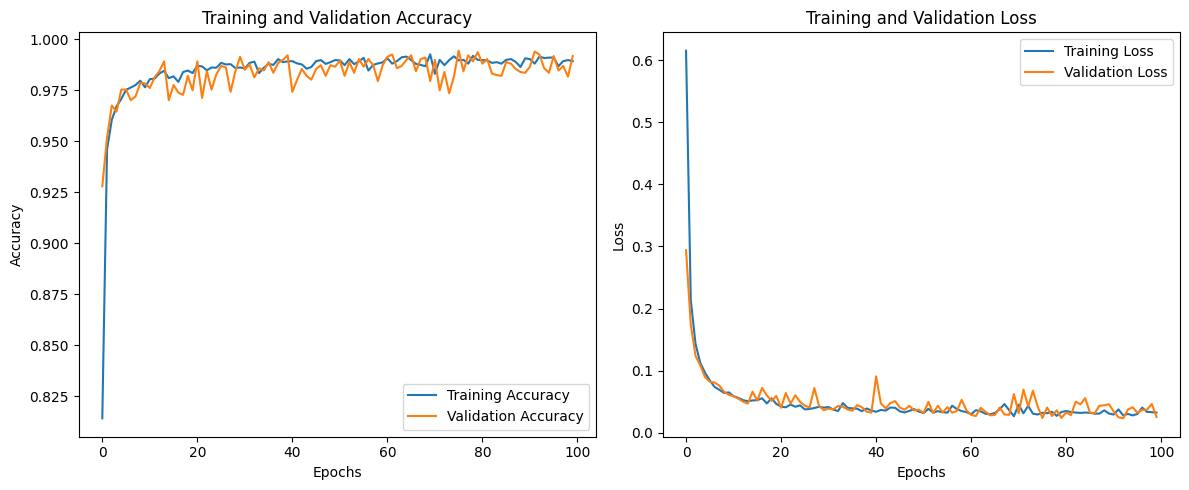

In [33]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## **9. Saving the Model**

In [27]:
model.save('classification_model.h5')